In [1]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pytorch_lightning as pl
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np

import json
import os
import glob
import pickle
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_ROOT = "../data/SensorData/"
user_file_prefix = "User"

TRAIN_FOLDER_PATH = os.path.join(DATA_ROOT, "train")
TEST_FOLDER_PATH = os.path.join(DATA_ROOT, "test")
RESULT_FOLDER_PATH = os.path.join(DATA_ROOT, "results")

os.makedirs(TRAIN_FOLDER_PATH, exist_ok=True)
os.makedirs(TEST_FOLDER_PATH, exist_ok=True)

data_files = sorted(glob.glob(os.path.join(DATA_ROOT, f"{user_file_prefix}*.csv")))
print(data_files)

['../data/SensorData/User00.csv', '../data/SensorData/User01.csv', '../data/SensorData/User02.csv', '../data/SensorData/User03.csv', '../data/SensorData/User04.csv', '../data/SensorData/User05.csv', '../data/SensorData/User06.csv', '../data/SensorData/User07.csv', '../data/SensorData/User08.csv', '../data/SensorData/User09.csv', '../data/SensorData/User10.csv', '../data/SensorData/User11.csv', '../data/SensorData/User12.csv', '../data/SensorData/User13.csv', '../data/SensorData/User14.csv', '../data/SensorData/User15.csv']


## Test with User00.csv

In [3]:
def segment(data_df, label_list, Window_size = 200, over_lap = 0.5, margin = 200):
    data_df_index_list = []
    index_label_list = []
    
    overlap_data = Window_size * over_lap

    index = 0
    loop = 0
    current_label = None
    
    while index < data_df.shape[0]:
        if index + Window_size >= data_df.shape[0]: break
    
        if current_label is not None and data_df['label'][index] == current_label:
            index += 1
            continue
            
        if pd.isna(data_df['label'][index]):
            index = index + 1
            continue

        count = 0
        while count < margin:
            count, index = count + 1, index + 1

        if index + Window_size >= data_df.shape[0]: break
        current_label = data_df.loc[index, 'label']

        while not pd.isna(data_df['label'][index + Window_size]) and data_df['label'][index + Window_size] == current_label:
#                 signal_data = data_df.iloc[index: index + Window_size, :]

            # Each data will be at size column(6 x 5 = 30) x Window_size
            # achieved by `data_df.loc[index: index + self.Window_size, :]` for index in data_df_index_list.
            # Data label will be `data_df.loc[index + self.Window_size, "label"]` for index in data_df_index_list.
            data_df_index_list.append(index)
            index = index + Window_size

            # add label of the last row of sequence
            index_label_list.append(data_df['label'][index])

            index = index - int(overlap_data)
            if index + Window_size >= data_df.shape[0]: break
                
    return data_df_index_list, index_label_list

In [4]:
data_df = pd.read_csv(data_files[0])
data_df

,accXA,accYA,accZA,agsXA,agsYA,agsZA,accXB,accYB,accZB,agsXB,...,agsXF,agsYF,agsZF,accXG,accYG,accZG,agsXG,agsYG,agsZG,label
0,10581,-2102,-3659,989,-647,-424,9780,86,-394,721,...,-3195,8792,-1487,9624,1114,-1587,-5325,-6494,2206,0
1,10637,-2021,-3691,1000,-636,-445,9788,164,-304,801,...,-3317,9067,-1737,9741,884,-1365,-5870,-6179,1907,0
2,10637,-2048,-3596,1024,-639,-473,9851,149,-443,882,...,-3164,8945,-2024,10022,523,-1133,-5371,-5702,1629,0
3,10566,-2084,-3522,1042,-622,-493,9897,278,-390,943,...,-3298,8573,-2359,10032,52,-833,-4236,-5112,1418,0
4,10546,-2075,-3481,1082,-616,-500,9854,283,-365,993,...,-3396,8865,-2390,10139,10,-699,-3126,-4431,1249,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31638,2390,-6623,4226,132,-157,-135,2346,7266,6094,-12,...,-298,1201,-1585,-66,-2335,-10501,-245,-74,-46,9
31639,2407,-6682,4282,35,-181,-126,2434,7327,6004,-45,...,-359,1304,-1579,-142,-2332,-10398,-207,-53,-52,9
31640,2414,-6682,4257,-58,-158,-129,2358,7271,6087,6,...,-481,1469,-1585,-103,-2298,-10464,-226,-45,-47,9
31641,2446,-6762,4208,-62,-151,-141,2329,7310,6067,54,...,-615,1628,-1664,-142,-2298,-10430,-218,-24,-47,9


In [5]:
data_df["label"].value_counts()

label
9    6571
8    5337
7    3172
2    3025
5    2577
4    2461
3    2403
6    2185
0    2079
1    1833
Name: count, dtype: int64

In [6]:
# important

label_list = ['歩行(平地)',
 '歩行(階段)',
 'ベッド上での起き上がり',
 'ベッド椅子間の乗り移り(立つ)',
 'ベッド椅子間の乗り移り(立たない)',
 '立ち座り',
 '座位保持・座位バランス',
 '立位保持・立位バランス',
 '関節可動域増大訓練(肩)',
 '関節可動域増大訓練(股関節)']

label_dict = dict(enumerate(label_list))

In [7]:
# important
eng_label_dict = dict(zip(
    label_list,
    ['Walking', 'Upstair', 'Bed_Standup', 'Change_Bed', 'Change_Bed_Standup', 'Sit_Down', 'Sit', 'Stand', 'Shoulder_Exercise', 'Hip_Exercise']
))

eng_label_list = [eng_label_dict[i] for i in label_list]

In [8]:
window_size = 256
data_df_index_list, index_label_list = segment(data_df, label_list, Window_size=window_size, over_lap=3/4)

In [9]:
data_list = []
for index, label_number in zip(data_df_index_list, index_label_list):
    x = data_df.iloc[index: index + window_size, :].drop(["label"], axis=1).values
    data_list.append(x)
data_list = np.array(data_list)

In [10]:
data_list.shape

(430, 256, 42)

In [11]:
sc = StandardScaler()

data_num, window_size, feature_num = data_list.shape
features_reshape = data_list.reshape(-1, feature_num)
features_norm = sc.fit_transform(features_reshape)

# convert back t feature size
features = features_norm.reshape(data_num, window_size, feature_num)

## create function to load feature from 1 csv file

In [12]:
def load_csv_data(csv_file_path):
    window_size = 256
    data_df = pd.read_csv(csv_file_path)
    data_df_index_list, index_label_list = segment(data_df, label_list, Window_size=window_size, over_lap=3/4)
    
    data_list = []
    for index, label_number in zip(data_df_index_list, index_label_list):
        x = data_df.iloc[index: index + window_size, :].drop(["label"], axis=1).values
        data_list.append(x)
    data_list = np.array(data_list)
    
    sc = StandardScaler()

    data_num, window_size, feature_num = data_list.shape
    features_reshape = data_list.reshape(-1, feature_num)
    features_norm = sc.fit_transform(features_reshape)

    # convert back t feature size
    features = features_norm.reshape(data_num, window_size, feature_num)
    
    return features, index_label_list

## create LOSO train, test dataset from 17 users

In [34]:
temp_dict = {}

for index, csv_file_path in enumerate(data_files):
    
    identifier = os.path.splitext(os.path.basename(csv_file_path))[0]
    features, index_label_list = load_csv_data(csv_file_path)
    
    temp_dict[identifier] = (features, index_label_list)

In [35]:
temp_dict_keys = sorted(temp_dict.keys())

for test_identifier in temp_dict_keys:
    
    train_features_list = []
    train_label_list = []

    for identifier in temp_dict_keys:
        
        if test_identifier == identifier:
            # test_set
            features, index_label_list = temp_dict[identifier]
            np.save(os.path.join(TEST_FOLDER_PATH, test_identifier), features)
            np.save(os.path.join(TEST_FOLDER_PATH, f"{test_identifier}_label"), index_label_list)

        else:
            # train_set
            train_features_list.append(temp_dict[identifier][0])
            train_label_list.append(temp_dict[identifier][1])

    train_features = np.concatenate(train_features_list, axis=0)
    train_label = np.concatenate(train_label_list, axis=0)

    np.save(os.path.join(TRAIN_FOLDER_PATH, test_identifier), train_features)
    np.save(os.path.join(TRAIN_FOLDER_PATH, f"{test_identifier}_label"), train_label)

    # np.save(os.path.join(TRAIN_FOLDER_PATH, test_identifier), temp_dict[identifier][0])
    # np.save(os.path.join(TRAIN_FOLDER_PATH, f"{test_identifier}_label"), temp_dict[identifier][1])
        

## Dataset, dataloader setup

In [36]:
save_filename_list = [(f"{identifier}.npy", f"{identifier}_label.npy") for identifier in temp_dict_keys]
save_filename_list

[('User00.npy', 'User00_label.npy'),
 ('User01.npy', 'User01_label.npy'),
 ('User02.npy', 'User02_label.npy'),
 ('User03.npy', 'User03_label.npy'),
 ('User04.npy', 'User04_label.npy'),
 ('User05.npy', 'User05_label.npy'),
 ('User06.npy', 'User06_label.npy'),
 ('User07.npy', 'User07_label.npy'),
 ('User08.npy', 'User08_label.npy'),
 ('User09.npy', 'User09_label.npy'),
 ('User10.npy', 'User10_label.npy'),
 ('User11.npy', 'User11_label.npy'),
 ('User12.npy', 'User12_label.npy'),
 ('User13.npy', 'User13_label.npy'),
 ('User14.npy', 'User14_label.npy'),
 ('User15.npy', 'User15_label.npy')]

In [37]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, feature_file, label_file, missing_sensor_id_list=None):
        self.features = np.load(feature_file)
        self.label = np.load(label_file)
        
        if missing_sensor_id_list is not None:
            for missing_sensor_id in missing_sensor_id_list:
                self.features[:, :, missing_sensor_id*6:(missing_sensor_id+1)*6] = 0
        
        assert len(self.features) == len(self.label), "features len is not equal to label len"
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        label = self.label[idx]
        return x, label

In [38]:
# test
dataset = CustomDataset(
    os.path.join(TRAIN_FOLDER_PATH, save_filename_list[0][0]),
    os.path.join(TRAIN_FOLDER_PATH, save_filename_list[0][1]),
    missing_sensor_id_list=[0]
)

In [39]:
dataset[0]

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -7.33699723e-02,  1.97070939e-02,  6.42542525e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.72382162e-02,  2.11596179e-02,  6.13775630e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.72382162e-02,  2.29026468e-02,  2.39806001e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.57543307e+00, -3.26619283e+00,  2.91619681e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.20139594e+00, -3.32923237e+00,  3.21508484e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.71392133e+00, -3.49249608e+00,  3.40609702e+00]]),
 0)

In [40]:
# test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [41]:
# test
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=True)

val_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=False)

## Model definition

In [42]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [43]:
class LSTMModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=30, output_size=6):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 200, input_size)
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        activation, _ = self.rnn1(x)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
        self.all_pred = test_pred_labels
        self.all_test = y
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)
        

In [44]:
model = LSTMModel()
summary(model)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              81,920
├─SelfAttention: 1-2                     --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Softmax: 2-4                      --
├─LSTM: 1-3                              132,096
├─SelfAttention: 1-4                     --
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       16,512
│    └─Softmax: 2-8                      --
├─Sequential: 1-5                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─BatchNorm1d: 2-14                 256
│    └─Dropout1d: 2-15      

In [45]:
# save_filename_list = [save_filename_list[0]]

In [46]:
print(list(combinations(range(7),2)))

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


In [47]:
save_filename_list = [save_filename_list[0]]
print(f"only use file: {save_filename_list}")

only use file: [('User00.npy', 'User00_label.npy')]


In [48]:

from tqdm.auto import tqdm
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

batch_size = 1024
patience = 20

all_test_pred = {}
missing_sensor_numbers = 0
print(f"start learning missing_sensor_numbers = {missing_sensor_numbers}")

for missing_index in combinations(range(7),missing_sensor_numbers):

    all_test = []
    all_pred = []

    # kfold_train_test_index_list = [kfold_train_test_index_list[0]]

    for i, save_filename_feature_label in enumerate(save_filename_list):
        print(f"\n*************{save_filename_feature_label[0]}*************")
        dataset = CustomDataset(
            os.path.join(TRAIN_FOLDER_PATH, save_filename_feature_label[0]),
            os.path.join(TRAIN_FOLDER_PATH, save_filename_feature_label[1]),
            missing_sensor_id_list=missing_index,
        )

        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        test_dataset =  CustomDataset(
            os.path.join(TEST_FOLDER_PATH, save_filename_feature_label[0]),
            os.path.join(TEST_FOLDER_PATH, save_filename_feature_label[1]),
            missing_sensor_id_list=missing_index,
        )

        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=batch_size,
            num_workers=4, # number of subprocesses to use for data loading
            shuffle=True)

        val_dataloader = DataLoader(
            val_dataset, 
            batch_size=batch_size,
            num_workers=2, # number of subprocesses to use for data loading
            shuffle=False)

        test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            num_workers=2, # number of subprocesses to use for data loading
            shuffle=False)

        model = LSTMModel(hidden_size=128, input_size=feature_num, output_size=len(label_list))

        tb_logger = TensorBoardLogger(".")

        trainer = pl.Trainer(
            logger=tb_logger,
            callbacks=[EarlyStopping(monitor="val_loss", patience=patience, mode="min")],
        )
        trainer.fit(model, train_dataloader, val_dataloader)
        trainer.test(model, test_dataloader)

        all_test.extend(model.all_test)
        all_pred.extend(model.all_pred)
        
    all_test_pred[missing_index] = (all_test, all_pred)

os.makedirs(RESULT_FOLDER_PATH, exist_ok=True)
with open(os.path.join(RESULT_FOLDER_PATH, "all_test_pred.pkl"), "wb") as f:
    pickle.dump(all_test_pred, f)

start learning missing_sensor_numbers = 0

*************User00.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes         | Out sizes                                           
-----------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 88.1 K | [1024, 200, 42]  | [[1024, 200, 128], [[1, 1024, 128], [1, 1024, 128]]]
1 | attention1 | SelfAttention | 49.5 K | [1024, 200, 128] | [1024, 200, 128]                                    
2 | rnn2       | LSTM          | 132 K  | [1024, 200, 128] | [[1024, 200, 128], [[1, 1024, 128], [1, 1024, 128]]]
3 | attention2 | SelfAttention | 49.5 K | [1024, 200, 128] | [1024, 200, 128]                                    
4 | seq_1      | Sequential    | 33.5 K | [1024, 128]      | [1024, 128]                                         
5

Epoch 0: 100%|████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.23it/s, v_num=2628, train_loss=1.450]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.06it/s, v_num=2628, train_loss=1.090, val_loss=2.270]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.11it/s, v_num=2628, train_loss=0.852, val_loss=2.240]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.11it/s, v_num=2628, train_loss=0.722, val_loss=2.190]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.10it/s, v_num=2628, train_loss=0.599, val_loss=2.090]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.10it/s, v_num=2628, train_loss=0.491, val_loss=1.910]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.48372092843055725
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [49]:
os.stat(os.path.join(RESULT_FOLDER_PATH, "all_test_pred.pkl"))

os.stat_result(st_mode=33204, st_ino=37635034, st_dev=66306, st_nlink=1, st_uid=1001, st_gid=1001, st_size=3195796, st_atime=1698205737, st_mtime=1698455266, st_ctime=1698455266)

In [50]:
with open(os.path.join(RESULT_FOLDER_PATH, "all_test_pred.pkl"), "rb") as f:
    all_test_pred = pickle.load(f)

<Axes: >

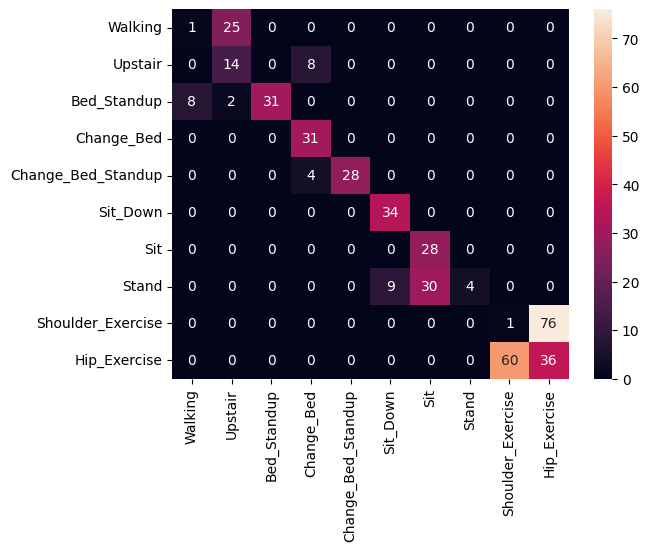

In [51]:
missing_index = ()

all_tall_test, all_pred = all_test_pred[missing_index]

# print("missing index", missing_index)
all_test_with_label = [label_list[i] for i in all_test]
all_pred_with_label = [label_list[i] for i in all_pred]

cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

TypeError: 'Axes' object is not subscriptable

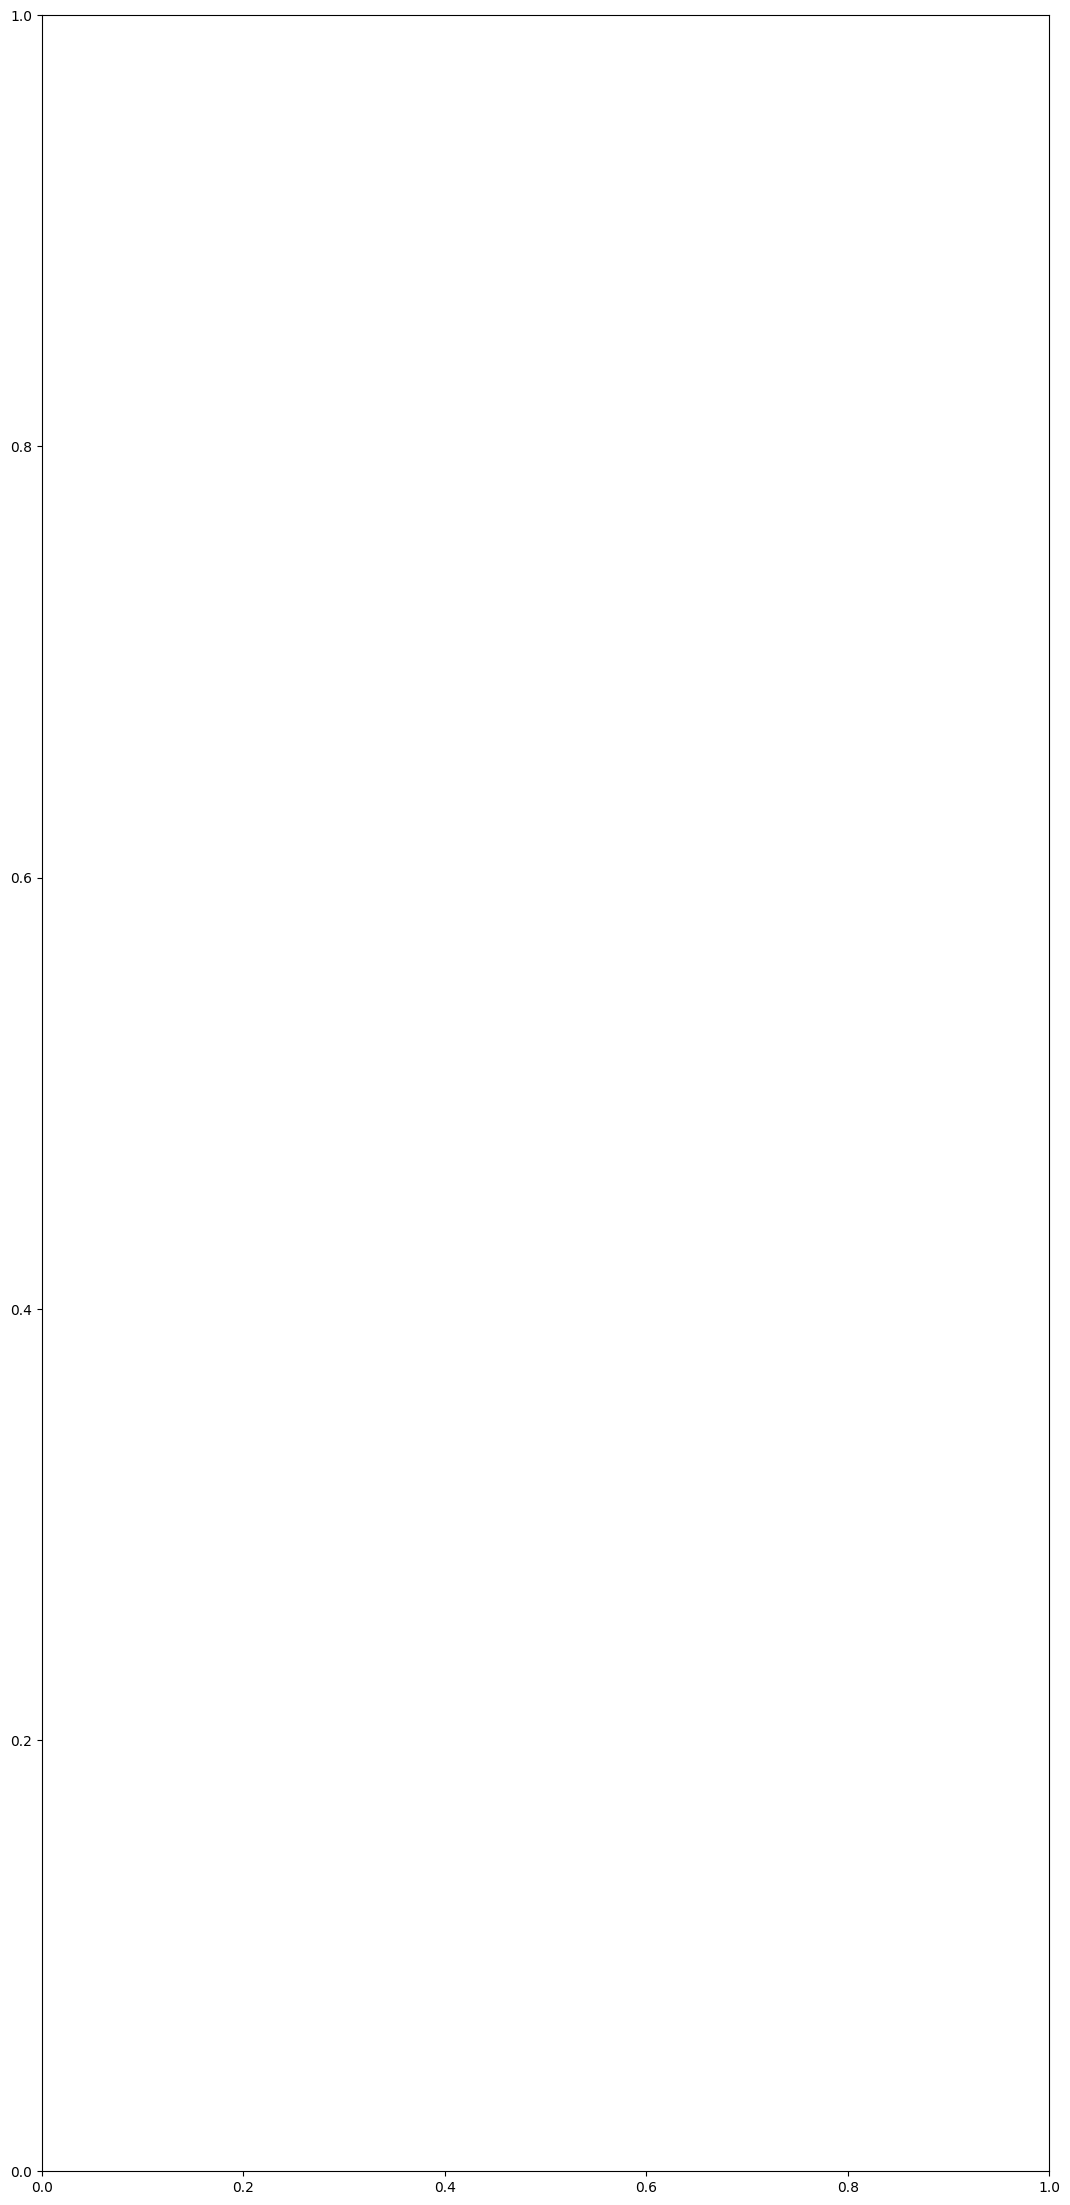

In [65]:
# missing_index = 2
row_item = 1

fig, ax = plt.subplots(len(all_test_pred.keys()) // row_item + len(all_test_pred.keys()) % row_item, row_item, figsize=(13,28))

for idx, missing_index in enumerate(all_test_pred.keys()):
    all_test, all_pred = all_test_pred[missing_index]
    
    # print("missing index", missing_index)
    all_test_with_label = [label_list[i] for i in all_test]
    all_pred_with_label = [label_list[i] for i in all_pred]
    
    cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
    sns.heatmap(cf, ax=ax[idx//row_item][idx%row_item], annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')
    ax[idx//row_item][idx%row_item].set_title(f"missing_index {missing_index} confusion matrix")
    
plt.tight_layout()
plt.savefig(os.path.join(RESULT_FOLDER_PATH, "all_test_pred.jpg"))

In [ ]:

# print("precision_recall_fscore_support: ")
# print()
# print(*eng_label_list, sep=" "*4)
# print(*precision_recall_fscore_support(all_test_with_label, all_pred_with_label, labels=label_list), sep="\n")

In [ ]:
all_test, all_pred = all_test_pred[missing_index]
print(all_test[0].cpu().item())

In [23]:
from sklearn.metrics import accuracy_score

for missing_index, (all_test, all_pred) in all_test_pred.items():
    
    all_test = list(map(lambda x: x.cpu().item(), all_test))
    all_pred = list(map(lambda x: x.cpu().item(), all_pred))
    
    print("missing_index", missing_index,":", accuracy_score(all_test, all_pred))
    # print(accuracy_score(all_test, all_pred))
    # print()

missing_index (0, 1) : 0.6069767441860465
missing_index (0, 2) : 0.9209302325581395
missing_index (0, 3) : 0.46744186046511627
missing_index (0, 4) : 0.5627906976744186
missing_index (0, 5) : 0.4558139534883721
missing_index (0, 6) : 0.39069767441860465
missing_index (1, 2) : 0.958139534883721
missing_index (1, 3) : 0.7023255813953488
missing_index (1, 4) : 0.3813953488372093
missing_index (1, 5) : 0.5
missing_index (1, 6) : 0.4627906976744186
missing_index (2, 3) : 0.9093023255813953
missing_index (2, 4) : 0.9348837209302325
missing_index (2, 5) : 0.9069767441860465
missing_index (2, 6) : 0.9534883720930233
missing_index (3, 4) : 0.43488372093023253
missing_index (3, 5) : 0.4558139534883721
missing_index (3, 6) : 0.5348837209302325
missing_index (4, 5) : 0.49767441860465117
missing_index (4, 6) : 0.6604651162790698
missing_index (5, 6) : 0.5558139534883721
